Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [2]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score

from scipy.optimize import linear_sum_assignment  # Hungarian algorithm

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,       # loose
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)



[Result] Smallest KMeans inertia (k=5): 924.3160


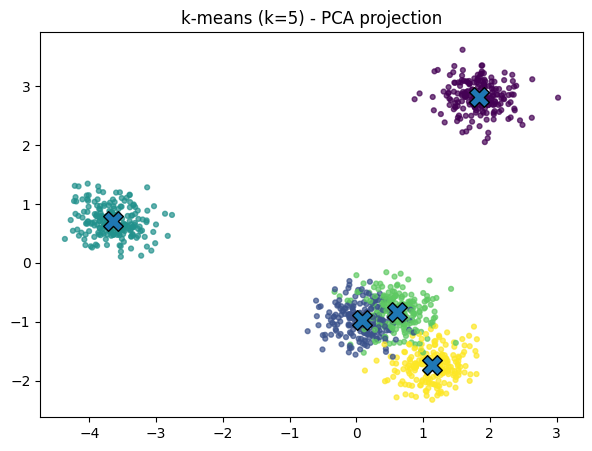


[Label mapping] pred -> true: {np.int64(3): np.int64(0), np.int64(1): np.int64(1), np.int64(0): np.int64(2), np.int64(2): np.int64(3), np.int64(4): np.int64(4)}
[Clustering accuracy after optimal permutation] 1.0000


,pred_0,pred_1,pred_2,pred_3,pred_4
true_0,200,0,0,0,0
true_1,0,200,0,0,0
true_2,0,0,200,0,0
true_3,0,0,0,200,0
true_4,0,0,0,0,200


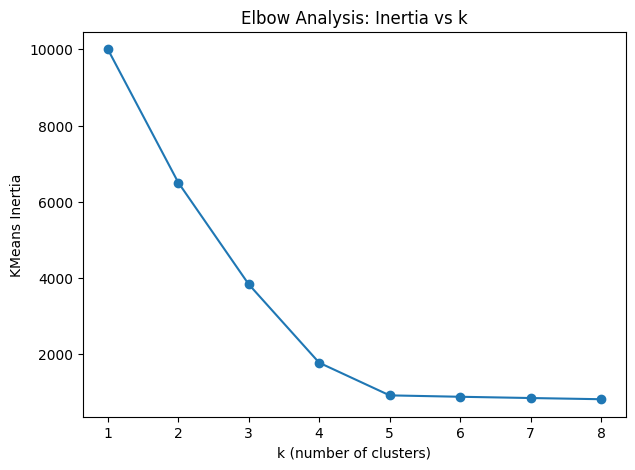

In [3]:
# your code here

# ========== perform a k-means cluster analysis with k = 5 ==========
k = 5
kmeans = KMeans(n_clusters=k, n_init=30, random_state=1)
kmeans.fit(X)

# ========== Report your smallest k-means inertia value ==========
best_inertia = kmeans.inertia_ #record the smallest inertia
print(f"\n[Result] Smallest KMeans inertia (k=5): {best_inertia:.4f}")

# ========== Make a 2D visualization of your clusters via PCA, including both the clusters (colored by cluster) and the cluster centers ==========
labels_pred = kmeans.labels_

pca = PCA(n_components=2, random_state=1)
X2 = pca.fit_transform(X)
centers2 = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(7, 5))
plt.scatter(X2[:, 0], X2[:, 1], c=labels_pred, s=12, alpha=0.7)
plt.scatter(centers2[:, 0], centers2[:, 1], marker='X', s=200, edgecolor='k', linewidth=1.0)
plt.title("k-means (k=5) - PCA projection")
plt.show()

# ========== make a confusion matrix that compares your assigned labels to the “true” labels ==========
confusion1 = confusion_matrix(y_true, labels_pred)

row, col = linear_sum_assignment(-confusion1) # to match the pred labels with true labels

pred_to_true = {pred: true for true, pred in zip(row, col)}

labels_remapped = np.vectorize(lambda p: pred_to_true[p])(labels_pred)

confusion1_aligned = confusion_matrix(y_true, labels_remapped)
acc = accuracy_score(y_true, labels_remapped)

print("\n[Label mapping] pred -> true:", pred_to_true)
print(f"[Clustering accuracy after optimal permutation] {acc:.4f}")

df_conf = pd.DataFrame(confusion1_aligned,
                       index=[f"true_{i}" for i in range(k)],
                       columns=[f"pred_{i}" for i in range(k)])
display(df_conf)

# ========== elbow analysis ==========
ks = list(range(1, 8 + 1))
inertias = []
for kk in ks:
    km = KMeans(n_clusters=kk, n_init=10, random_state=1).fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Analysis: Inertia vs k")
plt.xlabel("k (number of clusters)")
plt.ylabel("KMeans Inertia")
plt.xticks(ks)
plt.show()


# 2. Clustering Fashion-MNIST using $k$-means

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# =========================
# 0) Quick preview: 5×2 样例图（每类一张）
# =========================
import matplotlib.pyplot as plt
import numpy as np

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


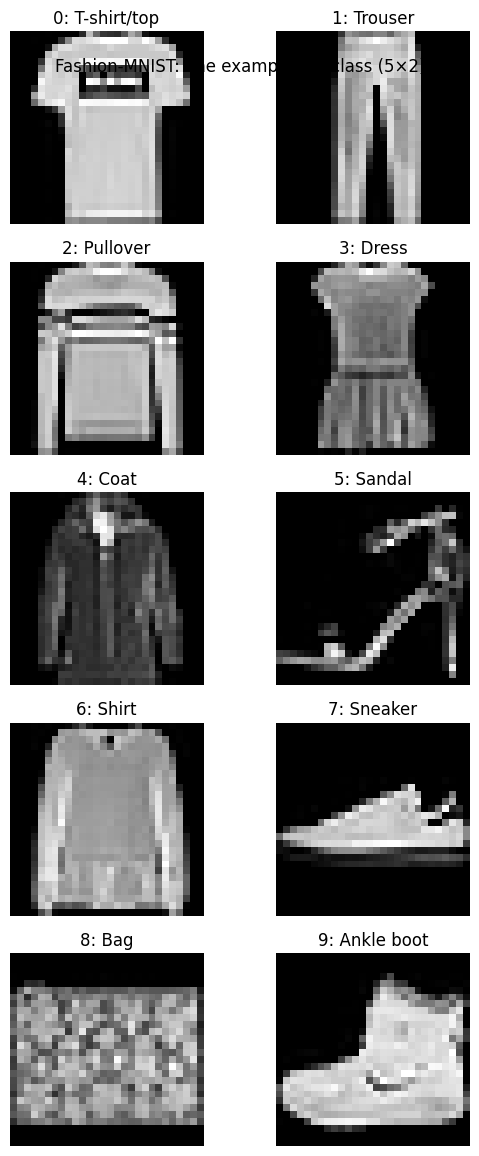

X_pca shape: (70000, 50)
Explained variance ratio (sum): 0.8009646
Inertia (on training subset or internal batches): 8592735.0

[Label mapping] pred -> true: {np.int64(9): np.int64(0), np.int64(8): np.int64(1), np.int64(3): np.int64(2), np.int64(1): np.int64(3), np.int64(4): np.int64(4), np.int64(7): np.int64(5), np.int64(2): np.int64(6), np.int64(5): np.int64(7), np.int64(6): np.int64(8), np.int64(0): np.int64(9)}
[Accuracy after optimal permutation] 0.5568


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0:T-shirt/top,3936,23,105,689,138,17,2044,4,44,0
true_1:Trouser,55,5082,50,1470,52,0,287,0,4,0
true_2:Pullover,95,4,3441,49,1294,5,2070,6,33,3
true_3:Dress,242,1563,21,3727,256,2,1187,0,1,1
true_4:Coat,20,42,2402,665,2834,5,1016,2,14,0
true_5:Sandal,0,0,0,5,1,4983,745,653,2,611
true_6:Shirt,1047,12,1516,403,1226,23,2668,9,93,3
true_7:Sneaker,0,0,0,0,0,2849,3,3955,0,193
true_8:Bag,13,8,218,50,1800,312,969,410,2926,294
true_9:Ankle boot,0,1,5,5,49,235,105,1178,1,5421


[ARI] 0.3342   [NMI] 0.5005


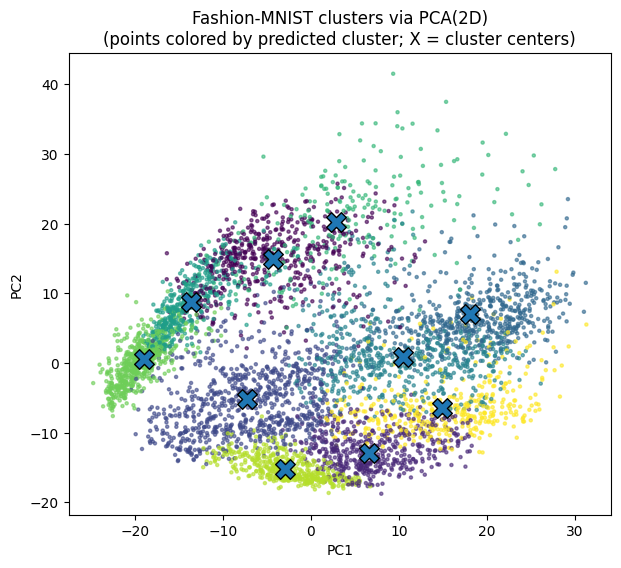

In [2]:
# your code here
CLASS_NAMES = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

# 找到每个类别的一个样本索引
examples_idx = []
for label in range(10):
    idx = np.where(y == label)[0][0]  # 取该类第一个出现的位置
    examples_idx.append(idx)

fig, axes = plt.subplots(5, 2, figsize=(6, 12))
for k, ax in enumerate(axes.ravel()):
    img = X[examples_idx[k]].reshape(28, 28)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{k}: {CLASS_NAMES[k]}")
    ax.axis("off")
plt.suptitle("Fashion-MNIST: one example per class (5×2)", y=0.92)
plt.tight_layout()
plt.show()

# =========================
# 1) 预处理：缩放 + PCA 降维
# =========================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# (可选) 把像素缩放到 [0,1]，再做标准化更稳定
X01 = X.astype(np.float32) / 255.0

# 标准化：每个像素特征 (列) 减均值除标准差
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X01).astype(np.float32)  # 转 float32 节省内存

# PCA 降到 50 维（经验上对 k-means 很有帮助，速度快）
pca = PCA(n_components=50, svd_solver="randomized", random_state=1)
X_pca = pca.fit_transform(X_scaled).astype(np.float32)

print("X_pca shape:", X_pca.shape)
print("Explained variance ratio (sum):", pca.explained_variance_ratio_.sum())

# =========================
# 2) 聚类：MiniBatchKMeans（更快）或 KMeans（更准）
# =========================
from sklearn.cluster import MiniBatchKMeans, KMeans

k = 10  # 10 个服饰类别
USE_MINIBATCH = True   # 如需普通 KMeans，把它设为 False

if USE_MINIBATCH:
    # MiniBatchKMeans：对大数据更友好
    km = MiniBatchKMeans(
        n_clusters=k,
        batch_size=2048,
        n_init=10,
        max_iter=100,
        random_state=1
    )
else:
    # 普通 KMeans：可能更稳定，但慢
    km = KMeans(
        n_clusters=k,
        n_init=10,
        random_state=1
    )

# 可选：只用一部分样本拟合，再对全量做 predict（进一步提速）
N_TRAIN = 30000
rng = np.random.default_rng(1)
train_idx = rng.choice(X_pca.shape[0], size=min(N_TRAIN, X_pca.shape[0]), replace=False)

km.fit(X_pca[train_idx])
labels_pred = km.predict(X_pca)        # 对全量 70k 做预测
centers_pca = km.cluster_centers_      # 在 50 维 PCA 空间里的簇中心
print("Inertia (on training subset or internal batches):", getattr(km, "inertia_", None))

# =========================
# 3) 评估：标签对齐的混淆矩阵 & 准确率 + 置换不变指标
# =========================
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment  # 匈牙利算法

# 原始混淆矩阵（true=行, pred=列）
C = confusion_matrix(y, labels_pred, labels=range(k))

# 用匈牙利算法在 -C 上做最小化，相当于最大化 C 的对角和 => 找到最佳一一对应
row_ind, col_ind = linear_sum_assignment(-C)
pred2true = {pred: true for true, pred in zip(row_ind, col_ind)}

# 重标记预测标签为“最佳匹配后的真值编号”
labels_aligned = np.vectorize(lambda p: pred2true[p])(labels_pred)

# 对齐后的混淆矩阵 + 准确率
C_aligned = confusion_matrix(y, labels_aligned, labels=range(k))
acc = accuracy_score(y, labels_aligned)

print("\n[Label mapping] pred -> true:", pred2true)
print("[Accuracy after optimal permutation] {:.4f}".format(acc))

# 用 pandas 展示表格更直观（可选）
import pandas as pd
df_conf = pd.DataFrame(
    C_aligned,
    index=[f"true_{i}:{CLASS_NAMES[i]}" for i in range(k)],
    columns=[f"pred_{i}" for i in range(k)]
)
display(df_conf)

# 置换不变指标（不需要对齐标签）
ari = adjusted_rand_score(y, labels_pred)
nmi = normalized_mutual_info_score(y, labels_pred)
print("[ARI] {:.4f}   [NMI] {:.4f}".format(ari, nmi))

# =========================
# 4) 可视化：PCA 到 2D（仅采样画图，避免 7 万点太挤）
# =========================
pca_vis = PCA(n_components=2, random_state=1)
X_vis = pca_vis.fit_transform(X_scaled).astype(np.float32)

# 抽样一部分点画散点图（如 5000）
PLOT_N = 5000
plot_idx = rng.choice(X_vis.shape[0], size=min(PLOT_N, X_vis.shape[0]), replace=False)

# 把“50 维中心”先还原到 scaled 空间，再投到 2D 方便一起画
centers_scaled = pca.inverse_transform(centers_pca).astype(np.float32)
centers_vis = pca_vis.transform(centers_scaled).astype(np.float32)

plt.figure(figsize=(7, 6))
plt.scatter(X_vis[plot_idx, 0], X_vis[plot_idx, 1],
            c=labels_pred[plot_idx], s=5, alpha=0.6)
plt.scatter(centers_vis[:, 0], centers_vis[:, 1],
            marker='X', s=200, edgecolor='k', linewidth=1.0)
plt.title("Fashion-MNIST clusters via PCA(2D)\n(points colored by predicted cluster; X = cluster centers)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# 3. Dimensionality reduction for Fashion-MNIST

Standardized X shape: (70000, 784)
Number of unique pairs sampled: 198362
k= 10 | corr(PCA)=0.9104 | corr(RandomProj)=0.8170
k= 20 | corr(PCA)=0.9577 | corr(RandomProj)=0.8801
k= 50 | corr(PCA)=0.9846 | corr(RandomProj)=0.9458
k=100 | corr(PCA)=0.9944 | corr(RandomProj)=0.9738
k=200 | corr(PCA)=0.9985 | corr(RandomProj)=0.9856


,k,corr_PCA,corr_RandomProjection
0,10,0.910414,0.817035
1,20,0.957683,0.880093
2,50,0.984553,0.945837
3,100,0.994391,0.973784
4,200,0.998534,0.985555


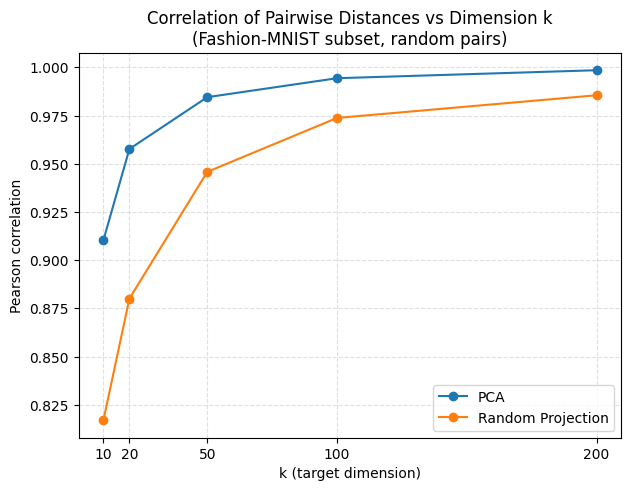

In [3]:
# your code here
# ============================================
# Dimensionality Reduction vs Distance Correlation
# PCA vs Gaussian Random Projection on Fashion-MNIST
# （从你已加载 X, y 的代码后继续）
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection

# -----------------------
# 1) 预处理：缩放到[0,1] + 标准化
# -----------------------
X01 = (X.astype(np.float32) / 255.0)
scaler = StandardScaler()
X_std = scaler.fit_transform(X01).astype(np.float32)

print("Standardized X shape:", X_std.shape)

# -----------------------
# 2) 采样子集与随机点对
# -----------------------
RNG_SEED = 1
rng = np.random.default_rng(RNG_SEED)

N_SUB = 5000         # 子样本数量（可调：2000~10000）
N_PAIRS = 200_000    # 随机点对数量（可调：5e4~5e5）
idx_sub = rng.choice(X_std.shape[0], size=min(N_SUB, X_std.shape[0]), replace=False)
X_sub = X_std[idx_sub]

# 生成随机无序点对 (i < j)，尽可能去重
i = rng.integers(0, X_sub.shape[0], size=N_PAIRS)
j = rng.integers(0, X_sub.shape[0], size=N_PAIRS)
mask = i != j
i, j = i[mask], j[mask]
pairs = np.stack([np.minimum(i, j), np.maximum(i, j)], axis=1)
pairs = np.unique(pairs, axis=0)  # 去重
# 若去重后数量比期望少，也OK；只是有效样本略少
print("Number of unique pairs sampled:", pairs.shape[0])

# -----------------------
# 3) 工具函数：在给定点对上计算欧式距离（分块避免占用过多内存）
# -----------------------
def pair_dists_on_pairs(Xmat, pairs, chunk=5000):
    out = np.empty(pairs.shape[0], dtype=np.float32)
    for s in range(0, pairs.shape[0], chunk):
        batch = pairs[s:s+chunk]
        diff = Xmat[batch[:, 0]] - Xmat[batch[:, 1]]   # [B, d]
        out[s:s+batch.shape[0]] = np.sqrt(np.sum(diff * diff, axis=1))
    return out

# 原空间距离（只算一次）
orig_d = pair_dists_on_pairs(X_sub, pairs, chunk=5000)

# -----------------------
# 4) PCA 与 随机投影：计算相关系数
# -----------------------
Ks = [10, 20, 50, 100, 200]
corr_pca = []
corr_rp  = []

for k in Ks:
    # --- PCA ---
    pca = PCA(n_components=k, svd_solver="randomized", random_state=RNG_SEED)
    X_pca = pca.fit_transform(X_sub).astype(np.float32)
    d_pca = pair_dists_on_pairs(X_pca, pairs, chunk=10000)
    # 与原距离做皮尔逊相关
    c_pca = np.corrcoef(orig_d, d_pca)[0, 1]
    corr_pca.append(c_pca)

    # --- Gaussian Random Projection ---
    grp = GaussianRandomProjection(n_components=k, random_state=RNG_SEED)
    X_rp = grp.fit_transform(X_sub).astype(np.float32)
    d_rp = pair_dists_on_pairs(X_rp, pairs, chunk=10000)
    c_rp = np.corrcoef(orig_d, d_rp)[0, 1]
    corr_rp.append(c_rp)

    print(f"k={k:3d} | corr(PCA)={c_pca:.4f} | corr(RandomProj)={c_rp:.4f}")

# 结果表
df_corr = pd.DataFrame({
    "k": Ks,
    "corr_PCA": corr_pca,
    "corr_RandomProjection": corr_rp
})
display(df_corr)

# -----------------------
# 5) 画图：相关系数 vs k
# -----------------------
plt.figure(figsize=(7, 5))
plt.plot(Ks, corr_pca, marker='o', label='PCA')
plt.plot(Ks, corr_rp, marker='o', label='Random Projection')
plt.title("Correlation of Pairwise Distances vs Dimension k\n(Fashion-MNIST subset, random pairs)")
plt.xlabel("k (target dimension)")
plt.ylabel("Pearson correlation")
plt.xticks(Ks)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


# 4. Clustering Fashion-MNIST using spectral clustering

Raw: (70000, 784) (70000,)
Standardized: (70000, 784)
Subsample: (3000, 784) (3000,)
PCA(50) shape: (3000, 50) | explained variance sum: 0.81417316

=== Spectral Clustering ===
[Label mapping] pred -> true: {np.int64(8): np.int64(0), np.int64(4): np.int64(1), np.int64(5): np.int64(2), np.int64(0): np.int64(3), np.int64(2): np.int64(4), np.int64(7): np.int64(5), np.int64(1): np.int64(6), np.int64(3): np.int64(7), np.int64(6): np.int64(8), np.int64(9): np.int64(9)}
Accuracy (after optimal permutation): 0.5727
ARI: 0.4113 | NMI: 0.5929 | Silhouette(50D): 0.1328


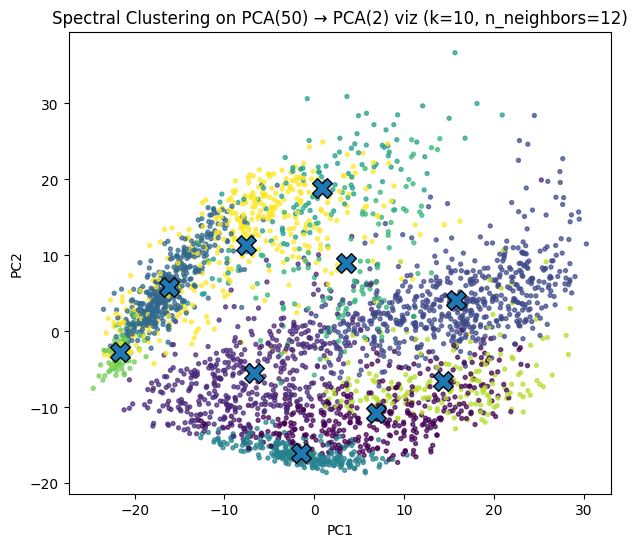


=== KMeans (for comparison) ===
[Label mapping] pred -> true: {np.int64(8): np.int64(0), np.int64(3): np.int64(1), np.int64(1): np.int64(2), np.int64(4): np.int64(3), np.int64(2): np.int64(4), np.int64(6): np.int64(5), np.int64(7): np.int64(6), np.int64(9): np.int64(7), np.int64(0): np.int64(8), np.int64(5): np.int64(9)}
Accuracy (after optimal permutation): 0.4833
ARI: 0.3355 | NMI: 0.4941 | Silhouette(50D): 0.1878

=== Summary (same 3000 subset, 50D) ===
Spectral:  ACC=0.5727  ARI=0.4113  NMI=0.5929  SIL=0.1328
KMeans  :  ACC=0.4833  ARI=0.3355  NMI=0.4941  SIL=0.1878


In [4]:
# your code here
# ============================================================
# Spectral Clustering on Fashion-MNIST (with k-means comparison)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from scipy.optimize import linear_sum_assignment

# -------------------------------
# 0) Ensure data (fallback load)
# -------------------------------
try:
    X, y  # if already defined earlier
except NameError:
    # Load Fashion-MNIST: X.shape = (70000, 784), y in {0..9}
    X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
    y = y.astype(int)

print("Raw:", X.shape, y.shape)

# -------------------------------
# 1) Scale & Standardize
# -------------------------------
X01 = (X.astype(np.float32) / 255.0)
scaler = StandardScaler()
X_std = scaler.fit_transform(X01).astype(np.float32)
print("Standardized:", X_std.shape)

# -------------------------------
# 2) Subsample (spectral-friendly)
# -------------------------------
RNG_SEED = 1
rng = np.random.default_rng(RNG_SEED)

N_SUB = 3000  # 调大更细致，但谱聚类会更慢更占内存
idx_sub = rng.choice(X_std.shape[0], size=min(N_SUB, X_std.shape[0]), replace=False)

X_sub = X_std[idx_sub]
y_sub = y[idx_sub]
print("Subsample:", X_sub.shape, y_sub.shape)

# -------------------------------
# 3) PCA to 50D (denoise + speed)
# -------------------------------
pca50 = PCA(n_components=50, svd_solver="randomized", random_state=RNG_SEED)
X50 = pca50.fit_transform(X_sub).astype(np.float32)
print("PCA(50) shape:", X50.shape, "| explained variance sum:", pca50.explained_variance_ratio_.sum())

# -------------------------------------
# 4) Spectral Clustering (k=10 classes)
# -------------------------------------
k = 10
N_NEI = 12  # neighbors for the affinity graph (10~15 are common choices)

spec = SpectralClustering(
    n_clusters=k,
    eigen_solver="arpack",         # 'arpack' is widely available; 'amg' needs pyamg
    affinity="nearest_neighbors",  # graph via k-NN
    n_neighbors=N_NEI,
    assign_labels="kmeans",        # k-means in the spectral embedding
    random_state=RNG_SEED,
    n_init=10
)

labels_spec = spec.fit_predict(X50)

# -------------------------------------
# 5) Evaluation helpers (Hungarian map)
# -------------------------------------
def align_and_report(y_true, y_pred, title=""):
    C = confusion_matrix(y_true, y_pred, labels=range(k))
    row_ind, col_ind = linear_sum_assignment(-C)  # maximize diagonal
    pred2true = {pred: true for true, pred in zip(row_ind, col_ind)}
    y_aligned = np.vectorize(lambda p: pred2true[p])(y_pred)

    C_aligned = confusion_matrix(y_true, y_aligned, labels=range(k))
    acc = accuracy_score(y_true, y_aligned)
    ari = adjusted_rand_score(y_true, y_pred)             # permutation-invariant
    nmi = normalized_mutual_info_score(y_true, y_pred)    # permutation-invariant
    sil = silhouette_score(X50, y_pred, metric="euclidean")  # quality within 50D space

    print(f"\n=== {title} ===")
    print("[Label mapping] pred -> true:", pred2true)
    print("Accuracy (after optimal permutation): {:.4f}".format(acc))
    print("ARI: {:.4f} | NMI: {:.4f} | Silhouette(50D): {:.4f}".format(ari, nmi, sil))

    df = pd.DataFrame(
        C_aligned,
        index=[f"true_{i}" for i in range(k)],
        columns=[f"pred_{i}" for i in range(k)]
    )
    return df, acc, ari, nmi, sil

df_spec, acc_spec, ari_spec, nmi_spec, sil_spec = align_and_report(y_sub, labels_spec, title="Spectral Clustering")

# -------------------------------------
# 6) Visualize in 2D (PCA for plotting)
# -------------------------------------
pca2 = PCA(n_components=2, random_state=RNG_SEED)
X2 = pca2.fit_transform(X50).astype(np.float32)

# Compute 2D centers (mean of points per cluster in the 2D viz space)
centers2 = np.vstack([X2[labels_spec == c].mean(axis=0) for c in range(k)])

plt.figure(figsize=(7, 6))
plt.scatter(X2[:, 0], X2[:, 1], c=labels_spec, s=8, alpha=0.7)
plt.scatter(centers2[:, 0], centers2[:, 1], marker='X', s=200, edgecolor='k', linewidth=1.0)
plt.title(f"Spectral Clustering on PCA(50) → PCA(2) viz (k={k}, n_neighbors={N_NEI})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# ---------------------------------------------------
# 7) (Optional but recommended) Compare with KMeans
#    on the same X50 and same subsample for fairness
# ---------------------------------------------------
km = KMeans(n_clusters=k, n_init=20, random_state=RNG_SEED)
labels_km = km.fit_predict(X50)

df_km, acc_km, ari_km, nmi_km, sil_km = align_and_report(y_sub, labels_km, title="KMeans (for comparison)")

# Print side-by-side metrics
print("\n=== Summary (same 3000 subset, 50D) ===")
print(f"Spectral:  ACC={acc_spec:.4f}  ARI={ari_spec:.4f}  NMI={nmi_spec:.4f}  SIL={sil_spec:.4f}")
print(f"KMeans  :  ACC={acc_km:.4f}  ARI={ari_km:.4f}  NMI={nmi_km:.4f}  SIL={sil_km:.4f}")

# 可选：显示对齐后的混淆矩阵（如需）
# display(df_spec)
# display(df_km)
